# UAVSAR Snow Pits 
Source: https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html

In [17]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, SiteData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape
import geopandas as gpd
from snowexsql.conversions import raster_to_rasterio
from snowexsql.conversions import points_to_geopandas, query_to_geopandas
import matplotlib.pyplot as z
import numpy as np

# Pit Site Identifier of interest
#site_id = '5N19'
site_name = 'Grand Mesa'
# Distance around the pit to collect data in meters
buffer_dist = 50

# Connect to the database we made.
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_name==site_name)
sites = q.all()

# Grab the pit location from a single layer
p = sites[0].geom

# Convert the point to a pyshapely
pit = to_shape(p)

# Convert it to a geopandas dataframe for easy plotting
df_pit = gpd.GeoSeries(pit)

In [8]:
df_pit

0    POINT (742229.000 4326414.000)
dtype: geometry

In [18]:
# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(p, buffer_dist))
buffered_pit = q.all()[0][0]

# Convert to a shapely shapefile object
circle = to_shape(buffered_pit)

# Convert to a geopandas dataframe
df_circle = gpd.GeoSeries(circle)

In [19]:
df_circle

0    POLYGON ((742279.000 4326414.000, 742278.039 4...
dtype: geometry

In [24]:
# Grab the rasters, union them and convert them as tiff when done
q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

# Only grab rasters that are the bare earth DEM from USGS
q = q.filter(ImageData.type == 'DEM').filter(ImageData.observers=='USGS')

# And grab rasters touching the circle
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffered_pit))

# Execute the query
rasters = q.all()

# Get the rasterio object of the raster
dataset = raster_to_rasterio(session, rasters)[0]

In [21]:
rasters

[(<memory at 0x7fc58ae590c0>,)]

In [28]:
dataset.read(1)

array([[3052.2861, 3052.2805, 3052.3496, ..., 3060.698 , 3060.7405,
        3060.779 ],
       [3052.3728, 3052.3406, 3052.329 , ..., 3060.717 , 3060.7756,
        3060.8113],
       [3052.4536, 3052.4268, 3052.372 , ..., 3060.7336, 3060.8022,
        3060.852 ],
       ...,
       [3060.9426, 3060.9329, 3060.9365, ..., 3055.076 , 3055.0554,
        3055.093 ],
       [3060.9563, 3060.9727, 3060.987 , ..., 3055.0227, 3054.9731,
        3055.0076],
       [3060.9639, 3060.9844, 3061.0007, ..., 3054.9504, 3054.8977,
        3054.9104]], dtype=float32)

In [31]:
sum(dataset.read(1)[0])/len(dataset.read(1)[0])

3056.2156896591187

In [38]:
def average_amplitudes(raster):
    """
    input: 2 dimensional array of list of amplitudes over multiple rasters
    output: average amplitude over entire raster
    """
    #create a variable to average each individual raster
    single_avgs = []
    #iterate over all rasters
    for i in range(len(raster)): 
        #compute and append the mean of the raster 
        single_avgs.append(sum(dataset.read(1)[i])/len(dataset.read(1)[i]))
    
    #compute the average amplitude over all rasters
    avg_amp = sum(single_avgs)/len(single_avgs) 
    
    return avg_amp

In [39]:
average_amplitudes(dataset.read(1))

3059.2608363013715

In [11]:
# Form a query for retrieving the sites that are within the circle
q = session.query(SiteData.geom).filter(gfunc.ST_Within(SiteData.geom, buffered_pit))

# Create a geopandas dataframe of SiteData geometry in the circle
nearby_pits = query_to_geopandas(q, engine)

In [12]:
nearby_pits

,geom
0,POINT (742229.000 4326414.000)


NameError: name 'dataset' is not defined

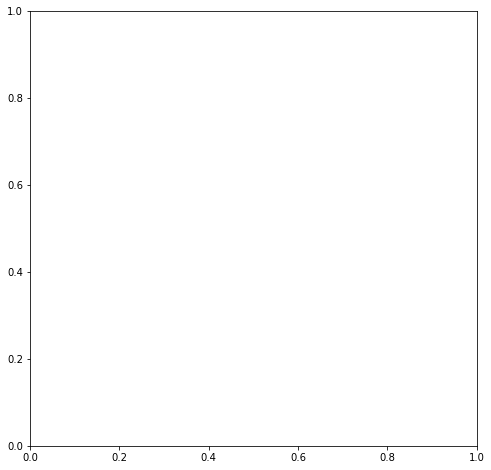

In [13]:
# Create a single plot to add everything to
fig, ax = plt.subplots(figsize=(8,8))

# Plot the DEM
img = show(dataset.read(1), ax=ax, transform=dataset.transform, cmap='terrain')

# Plot the contours of the DEM (Just for kicks!) at 10m intervals
show(dataset.read(1), contour=True, levels=[s for s in np.arange(3000, 4000, 10)], colors='dimgray', ax=ax, transform=dataset.transform)

# Plot the circle as blue with slight transparency
df_circle.plot(ax=ax, color='b', alpha=0.4, edgecolor='black')

# Plot the nearby pits as purple triangles
nearby_pits.plot(ax=ax, color='purple', marker='^', label='Nearby Pits',  edgecolor='black', markersize=150)

# Plot pit as a red triangle
df_pit.plot(ax=ax, color='r', marker='^', label=site_id,  edgecolor='black', markersize=150)

# Don't use scientific notation on the axis ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Add x/y labels, a title, a legend and avoid overlapping labels
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} w/ {}m Radius Circle on USGS DEM'.format(site_id, buffer_dist))
ax.legend()
plt.tight_layout()

# Merging Amplitudes

In [1]:
import pandas as pd

In [3]:
def average_polarizations(csv1, csv2):
    """
    Input: two csv name paths, each containing a pit_id and amplitude
    
    Output: Pandas dataframe containing pit_id's and average amperage between the two
    
    """
    #read in files
    c1 = pd.read_csv(csv1)
    c2 = pd.read_csv(csv2)
    
    #rename columns, remove unnamed index columns
    c1 = c1[['0', '1']]
    c1.columns = ['pit_id', 'c1_amp']
    c2 = c2[['0', '1']]
    c2.columns = ['pit_id', 'c2_amp']
    
    #merge together on pit_id
    polars = c1.merge(c2, on=['pit_id'], how='left')
    polars['avg_amp'] = (polars.c1_amp + polars.c2_amp) / 2
    
    return polars[['pit_id', 'avg_amp']]

In [7]:
HH1 = '../Anuhya/amplitudes_HH.csv'
HH2 = '../Anuhya/amplitudes_HH2.csv'
HH_avg = average_polarizations(HH1, HH2)
HH_avg.head()

,pit_id,avg_amp
0,COGM2S37_20200201,0.090272
1,COGMSO_20200321_1006,0.151810
2,COGM5S31_20200130,0.090272
3,COGMCO_20200318_0825,0.149241
4,COGM2C2_20200131,0.071491


In [9]:
HV1 = '../Anuhya/amplitudes_HV.csv'
HV2 = '../Anuhya/amplitudes_HV2.csv'
HV_avg = average_polarizations(HV1, HV2)
HV_avg.head()

,pit_id,avg_amp
0,COGM2S37_20200201,0.033710
1,COGMSO_20200321_1006,0.054633
2,COGM5S31_20200130,0.033710
3,COGMCO_20200318_0825,0.049581
4,COGM2C2_20200131,0.022654


In [10]:
VV1 = '../Anuhya/amplitudes_VV.csv'
VV2 = '../Anuhya/amplitudes_VV2.csv'
VV_avg = average_polarizations(VV1, VV2)
VV_avg.head()

,pit_id,avg_amp
0,COGM2S37_20200201,0.071622
1,COGMSO_20200321_1006,0.123060
2,COGM5S31_20200130,0.071622
3,COGMCO_20200318_0825,0.103564
4,COGM2C2_20200131,0.068166


In [11]:
VH1 = '../Anuhya/amplitudes_VH.csv'
VH2 = '../Anuhya/amplitudes_VH2.csv'
VH_avg = average_polarizations(VH1, VH2)
VH_avg.head()

,pit_id,avg_amp
0,COGM2S37_20200201,0.034575
1,COGMSO_20200321_1006,0.054984
2,COGM5S31_20200130,0.034575
3,COGMCO_20200318_0825,0.047769
4,COGM2C2_20200131,0.025515


In [12]:
HH_avg.columns = ['pit_id', 'HH']
HV_avg.columns = ['pit_id', 'HV']
VV_avg.columns = ['pit_id', 'VV']
VH_avg.columns = ['pit_id', 'VH']

Amplitudes = HH_avg.merge(HV_avg, on='pit_id', how='left')
Amplitudes = Amplitudes.merge(VH_avg, on='pit_id', how='left')
Amplitudes = Amplitudes.merge(VV_avg, on='pit_id', how='left')
Amplitudes

,pit_id,HH,HV,VH,VV
0,COGM2S37_20200201,0.090272,0.033710,0.034575,0.071622
1,COGMSO_20200321_1006,0.151810,0.054633,0.054984,0.123060
2,COGM5S31_20200130,0.090272,0.033710,0.034575,0.071622
3,COGMCO_20200318_0825,0.149241,0.049581,0.047769,0.103564
4,COGM2C2_20200131,0.071491,0.022654,0.025515,0.068166
...,...,...,...,...,...
123,COGM2S3_20200129,0.069852,0.027647,0.032221,0.069523
124,COGMSO_20191219_1600,0.151810,0.054633,0.054984,0.123060
125,COGM1N20_20200205,0.094391,0.034148,0.036019,0.078598
126,COGM2S35_20200130,0.090272,0.033710,0.034575,0.071622


In [16]:
data = pd.read_csv('../Shrusti/final_data.csv')

In [15]:
pits = data[['pit_id', 'height', 'grain_size', 'density', 'temperature']]
pits.head()

,pit_id,height,grain_size,density,temperature
0,COGM1C1_20200131,83,1.375000,249.388889,-5.710000
1,COGM1C1_20200208,77,1.571429,289.187500,-4.822222
2,COGM1C14_20200131,81,2.150000,263.142857,-5.488889
3,COGM1C5_20200212,75,1.416667,302.833333,-6.577778
4,COGM1C7_20200131,96,1.750000,277.833333,-5.990909


In [18]:
final_data = Amplitudes.merge(pits, how = 'left', on = 'pit_id')

In [19]:
final_data.to_csv('final_data(2).csv')